In [1]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def balanced_error_rate(y_true, y_test):
    
    conf = confusion_matrix(y_true, y_test)
    
    return 0.5 * (conf[0,1] / conf[0].sum()) + 0.5 * (conf[1,0] / conf[1].sum())

def error_metrics(y_true, y_test):
    
    print('BER: ', balanced_error_rate(y_true, y_test))
    print('F1: ', f1_score(y_true, y_test))

In [3]:
def load_data(data_name):
    '''data_name:  'arcene', 'dorothea', 'gisette', 'dexter', or 'madelon'. '''
    
    fp = '/home/james/anaconda3/data/' + data_name.upper() + '/'
    
    if data_name not in ['dorothea', 'dexter']:
        
        X_train = np.loadtxt(fp + data_name + '_train.data')
        y_train = np.loadtxt(fp + data_name + '_train.labels')
        X_test = np.loadtxt(fp + data_name + '_valid.data')
        y_test = np.loadtxt(fp + data_name + '_valid.labels')
        y_train = np.asanyarray((y_train + 1) // 2, dtype = 'i8')
        y_test = np.asanyarray((y_test + 1) // 2, dtype = 'i8')
        
    else:
        
        X_train = np.load(fp + data_name + '_train.npy')
        y_train = np.loadtxt(fp + data_name + '_train.labels')
        X_test = np.load(fp + data_name + '_valid.npy')
        y_test = np.loadtxt(fp + data_name + '_valid.labels')
        y_train = np.asanyarray((y_train + 1) // 2, dtype = 'i8')
        y_test = np.asanyarray((y_test + 1) // 2, dtype = 'i8')
        
        
    print(data_name.upper() + ' Data:')
    print('Training data info: ')
    print(X_train.shape[0], ' samples, ', X_train.shape[1], ' features.')
    print(int(y_train.sum()), ' positve samples, ', int(X_train.shape[0] - y_train.sum()), ' negative samples')
    print('-------------------------------')
    print('Test data info: ')
    print(X_test.shape[0], ' samples.')
    print(int(y_test.sum()), ' positve samples, ', int(X_test.shape[0] - y_test.sum()), ' negative samples')
    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = load_data('arcene')

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples


In [5]:
clf = LogisticRegression(C=0.0001, class_weight='balanced')

In [6]:
#clf = SVC(class_weight='balanced')

In [7]:
clf.fit(X_train, y_train)
print('Logistic Regression on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))

Logistic Regression on Full Feature Space
-----------------------------------------
BER:  0.167207792208
F1:  0.809523809524


In [34]:
-

In [47]:
from tqdm import tqdm_notebook as tqdm

def run_pso(swarm_size, num_iter, size_reg, clf, itr=1):
    
    print('Initializing the swarm....')
    
    swarm = []

    for k in range(swarm_size):
    
        swarm.append(Particle(X_train.shape[1]))
    
    swarm[0].fit_clf(clf, size_reg, X_train, y_train)

    g_best_loc = 0
    g_best_pos = np.copy(swarm[0].p)
    g_best_score = np.copy(swarm[0].ber) + size_reg * (np.copy(swarm[0].num_feats) / len(swarm[0].p))

    for k in range(1,len(swarm)):
    
        swarm[k].fit_clf(clf, size_reg,  X_train, y_train)
    
        if g_best_score > swarm[k].ber + size_reg * (swarm[k].num_feats / len(swarm[k].p)):
        
            g_best_loc = k
            g_best_pos = np.copy(swarm[k].p)
            g_best_score = np.copy(swarm[k].ber) + size_reg * (np.copy(swarm[k].num_feats) / len(swarm[k].p))
            
    print('Iteration ', itr, ' Initial Best (BER, f1, num_feats, score): (', swarm[g_best_loc].ber,
                  ', ', swarm[g_best_loc].f1, ', ', swarm[g_best_loc].num_feats,', ', g_best_score, ')')

    for iteration in tqdm(range(num_iter)):
    
        for k in range(len(swarm)):
        
            update_velocity(swarm[k], g_best_pos)
            update_position(swarm[k])
            swarm[k].fit_clf(clf, size_reg, X_train, y_train)
    
        for k in range(len(swarm)):
    
            if g_best_score > swarm[k].ber + size_reg * (swarm[k].num_feats / len(swarm[k].p)):
            
                g_best_loc = k
                g_best_pos = np.copy(swarm[k].p)
                g_best_score = np.copy(swarm[k].ber) + size_reg * (np.copy(swarm[k].num_feats) / len(swarm[k].p))
                #print(' Iteration ', itr, ' Current Best (BER, f1, num_feats, score): (', swarm[k].ber,
                #  ', ', swarm[k].f1, ', ', swarm[k].num_feats,', ', g_best_score, ')')
                
        b_feat = int(min(len(swarm[0].p), 3 * swarm[g_best_loc].num_feats))
        rand_ind = np.random.choice(np.arange(swarm_size, dtype='i8'), replace=False, size=15)
        
        for ind in rand_ind:
            
            if ind != g_best_loc:
                
                swarm[ind] = Particle(X_train.shape[1], b_feat)
                swarm[ind].fit_clf(clf, size_reg, X_train, y_train)
            
    best_part = Particle(X_train.shape[-1])
    best_part.p = g_best_pos
    best_part.update_locs()
    best_part.fit_clf(clf, size_reg, X_train, y_train)
    print(' Final Best (BER, f1, num_feats): (', best_part.ber,
                  ', ', best_part.f1, ', ', best_part.num_feats ,')')
    return best_part

In [39]:
# Run Arcene Test

X_train, y_train, X_test, y_test = load_data('arcene')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_arcene = []

for exp in range(3):
    
    best_arcene.append(run_pso(150, 100, 0.01, clf, exp+1))
    
arcene_ber = np.asanyarray([100*x.ber for x in best_arcene])
arcene_f1 = np.asanyarray([100*x.f1 for x in best_arcene])
arcene_num_feats = np.asanyarray([x.num_feats for x in best_arcene])

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.167207792208
F1:  0.809523809524
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.135551948052 ,  0.847058823529 ,  3526 ,  0.139077948052 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.121753246753 ,  0.863636363636 ,  3319 ,  0.125072246753 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.11525974026 ,  0.870588235294 ,  4806 ,  0.12006574026 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.112824675325 ,  0.873563218391 ,  2564 ,  0.115388675325 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0949675324675 ,  0.

/home/james/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  418 ,  0.0117816363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  413 ,  0.0117766363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  403 ,  0.0117666363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  401 ,  0.0117646363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  398 ,  0.0117616363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  397 ,  0.0117606363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  394 ,  0.0117576363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  382 ,  0.0117456363636 )
 Iteration  1  Current Best (BER

 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  260 ,  0.0229872727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  259 ,  0.0229862727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  257 ,  0.0229842727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  250 ,  0.0229772727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  248 ,  0.0229752727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  246 ,  0.0229732727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  245 ,  0.0229722727273 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  242 ,  0.0229692727273 )
 Iteration  2  Current Best (BER

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  615 ,  0.0233422727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  534 ,  0.0232612727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  530 ,  0.0232572727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  507 ,  0.0232342727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  469 ,  0.0231962727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  429 ,  0.0231562727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  428 ,  0.0231552727273 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  392 ,  0.0231192727273 )
 Iteration  3  Current Best (BER

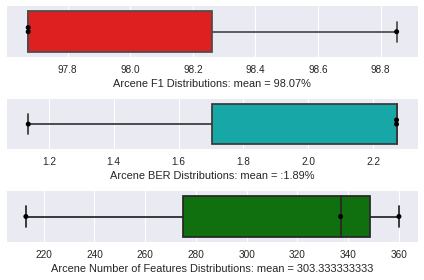

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(arcene_f1, color='k', ax=ax1)
sns.boxplot(arcene_f1, color='r', ax=ax1)
ax1.set_xlabel('Arcene F1 Distributions: mean = ' + str(round(arcene_f1.mean(),2)) + '%')
sns.swarmplot(arcene_ber, color='k', ax=ax2)
sns.boxplot(arcene_ber, color='c', ax=ax2)
ax2.set_xlabel('Arcene BER Distributions: mean = :' + str(round(arcene_ber.mean(),2)) + '%')
sns.swarmplot(arcene_num_feats, color='k', ax=ax3)
sns.boxplot(arcene_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Arcene Number of Features Distributions: mean = ' + str(arcene_num_feats.mean()) )
plt.tight_layout()

In [42]:
# Run Dexter Test

X_train, y_train, X_test, y_test = load_data('dexter')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_dex = []

for exp in range(3):
    
    best_dex.append(run_pso(150, 100, 0.01, clf, exp+1))
    
dex_ber = np.asanyarray([100*x.ber for x in best_dex])
dex_f1 = np.asanyarray([100*x.f1 for x in best_dex])
dex_num_feats = np.asanyarray([x.num_feats for x in best_dex])


DEXTER Data:
Training data info: 
300  samples,  20000  features.
150  positve samples,  150  negative samples
-------------------------------
Test data info: 
300  samples.
150  positve samples,  150  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.0733333333333
F1:  0.929936305732
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.0566666666667 ,  0.943894389439 ,  13286 ,  0.0633096666667 )

 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0566666666667 ,  0.945337620579 ,  10901 ,  0.0621171666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0533333333333 ,  0.947712418301 ,  12043 ,  0.0593548333333 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.05 ,  0.951140065147 ,  12869 ,  0.0564345 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.05 ,  0.95114006


Initializing the swarm....
Iteration  2  Initial Best (BER, f1, num_feats, score): ( 0.0566666666667 ,  0.944262295082 ,  10247 ,  0.0617901666667 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0533333333333 ,  0.948387096774 ,  12476 ,  0.0595713333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.05 ,  0.950166112957 ,  12317 ,  0.0561585 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.05 ,  0.950166112957 ,  11592 ,  0.055796 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.953947368421 ,  14309 ,  0.0538211666667 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.95737704918 ,  15794 ,  0.0512303333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.962962962963 ,  11997 ,  0.0426651666667 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0333333333333 ,  0.966666666667 ,  12737 ,  0.0397018333333 )
 Iteration  2  Current Be

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.95737704918 ,  12539 ,  0.0496028333333 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.95737704918 ,  12504 ,  0.0495853333333 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  13058 ,  0.046529 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  13026 ,  0.046513 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  13015 ,  0.0465075 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  12897 ,  0.0464485 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  12751 ,  0.0463755 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  12709 ,  0.0463545 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960526315789 ,  12645 ,  0.0463225 )
 Iteration  3  C

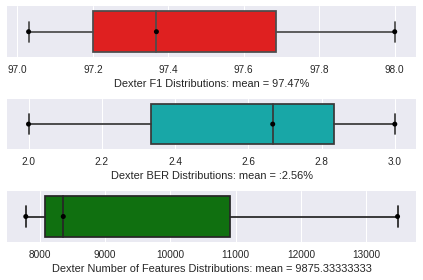

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(dex_f1, color='k', ax=ax1)
sns.boxplot(dex_f1, color='r', ax=ax1)
ax1.set_xlabel('Dexter F1 Distributions: mean = ' + str(round(dex_f1.mean(),2)) + '%')
sns.swarmplot(dex_ber, color='k', ax=ax2)
sns.boxplot(dex_ber, color='c', ax=ax2)
ax2.set_xlabel('Dexter BER Distributions: mean = :' + str(round(dex_ber.mean(),2)) + '%')
sns.swarmplot(dex_num_feats, color='k', ax=ax3)
sns.boxplot(dex_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Dexter Number of Features Distributions: mean = ' + str(dex_num_feats.mean()) )
plt.tight_layout()

In [ ]:
# Run Gisette Test

X_train, y_train, X_test, y_test = load_data('gisette')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_gst = []

for exp in range(3):
    
    best_gst.append(run_pso(150, 100, 0.01, clf, exp+1))
    
gst_ber = np.asanyarray([100*x.ber for x in best_gst])
gst_f1 = np.asanyarray([100*x.f1 for x in best_gst])
gst_num_feats = np.asanyarray([x.num_feats for x in best_gst])

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(gst_f1, color='k', ax=ax1)
sns.boxplot(gst_f1, color='r', ax=ax1)
ax1.set_xlabel('Gisette F1 Distributions: mean = ' + str(round(gst_f1.mean(),2)) + '%')
sns.swarmplot(gst_ber, color='k', ax=ax2)
sns.boxplot(gst_ber, color='c', ax=ax2)
ax2.set_xlabel('Gisette BER Distributions: mean = :' + str(round(gst_ber.mean(),2)) + '%')
sns.swarmplot(gst_num_feats, color='k', ax=ax3)
sns.boxplot(gst_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Gisette Number of Features Distributions: mean = ' + str(gst_num_feats.mean()) )
plt.tight_layout()

In [44]:
# Run Dorothea Test

X_train, y_train, X_test, y_test = load_data('dorothea')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_dor = []

for exp in range(3):
    
    best_dor.append(run_pso(150, 100, 0.01, clf, exp+1))
    
dor_ber = np.asanyarray([100*x.ber for x in best_dor])
dor_f1 = np.asanyarray([100*x.f1 for x in best_dor])
dor_num_feats = np.asanyarray([x.num_feats for x in best_dor])

DOROTHEA Data:
Training data info: 
800  samples,  100000  features.
78  positve samples,  722  negative samples
-------------------------------
Test data info: 
350  samples.
34  positve samples,  316  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.138216679077
F1:  0.712328767123
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.102010424423 ,  0.716049382716 ,  71853 ,  0.109195724423 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.101545048399 ,  0.659340659341 ,  48602 ,  0.106405248399 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0952159344751 ,  0.689655172414 ,  46999 ,  0.0999158344751 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0952159344751 ,  0.689655172414 ,  43563 ,  0.0995722344751 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0895

 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0547282204021 ,  0.780487804878 ,  33317 ,  0.0580599204021 )

Initializing the swarm....
Iteration  2  Initial Best (BER, f1, num_feats, score): ( 0.0983804914371 ,  0.674157303371 ,  50893 ,  0.103469791437 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0994973938943 ,  0.62 ,  34207 ,  0.102918093894 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0967982129561 ,  0.681818181818 ,  57629 ,  0.102561112956 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0979151154133 ,  0.626262626263 ,  40667 ,  0.101981815413 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0915860014892 ,  0.652631578947 ,  41906 ,  0.0957766014892 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0900037230082 ,  0.659574468085 ,  42655 ,  0.0942692230082 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0852568875652 ,  0.681318681319 ,  41472 ,  0.0894040875652 )
 It

 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0495160089352 ,  0.741573033708 ,  30210 ,  0.0525370089352 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0495160089352 ,  0.741573033708 ,  30209 ,  0.0525369089352 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0495160089352 ,  0.741573033708 ,  30207 ,  0.0525367089352 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0495160089352 ,  0.741573033708 ,  30201 ,  0.0525361089352 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0495160089352 ,  0.741573033708 ,  30135 ,  0.0525295089352 )

Initializing the swarm....
Iteration  3  Initial Best (BER, f1, num_feats, score): ( 0.0972635889799 ,  0.74358974359 ,  50061 ,  0.10226968898 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0974497393894 ,  0.587155963303 ,  38141 ,  0.101263839389 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.092051377513 ,  0.705882352941 ,  49414 ,  0.0969927775

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0463514519732 ,  0.758620689655 ,  32500 ,  0.0496014519732 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0463514519732 ,  0.758620689655 ,  32495 ,  0.0496009519732 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0463514519732 ,  0.758620689655 ,  32474 ,  0.0495988519732 )



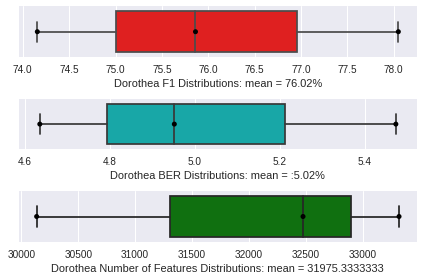

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(dor_f1, color='k', ax=ax1)
sns.boxplot(dor_f1, color='r', ax=ax1)
ax1.set_xlabel('Dorothea F1 Distributions: mean = ' + str(round(dor_f1.mean(),2)) + '%')
sns.swarmplot(dor_ber, color='k', ax=ax2)
sns.boxplot(dor_ber, color='c', ax=ax2)
ax2.set_xlabel('Dorothea BER Distributions: mean = :' + str(round(dor_ber.mean(),2)) + '%')
sns.swarmplot(dor_num_feats, color='k', ax=ax3)
sns.boxplot(dor_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Dorothea Number of Features Distributions: mean = ' + str(dor_num_feats.mean()) )
plt.tight_layout()

In [48]:
# Run Arcene Test

X_train, y_train, X_test, y_test = load_data('arcene')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_arcene = []

for exp in range(25):
    
    best_arcene.append(run_pso(150, 100, 0.01, clf, exp+1))
    
arcene1_ber = np.asanyarray([100*x.ber for x in best_arcene])
arcene1_f1 = np.asanyarray([100*x.f1 for x in best_arcene])
arcene1_num_feats = np.asanyarray([x.num_feats for x in best_arcene])

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.167207792208
F1:  0.809523809524
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.112824675325 ,  0.873563218391 ,  1892 ,  0.114716675325 )


 Final Best (BER, f1, num_feats): ( 0.0405844155844 ,  0.954545454545 ,  459 )
Initializing the swarm....
Iteration  2  Initial Best (BER, f1, num_feats, score): ( 0.124188311688 ,  0.860465116279 ,  645 ,  0.124833311688 )


/home/james/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 Final Best (BER, f1, num_feats): ( 0.0267857142857 ,  0.967032967033 ,  78 )
Initializing the swarm....
Iteration  3  Initial Best (BER, f1, num_feats, score): ( 0.116883116883 ,  0.869565217391 ,  2078 ,  0.118961116883 )

 Final Best (BER, f1, num_feats): ( 0.0292207792208 ,  0.966292134831 ,  118 )
Initializing the swarm....
Iteration  4  Initial Best (BER, f1, num_feats, score): ( 0.11525974026 ,  0.870588235294 ,  3513 ,  0.11877274026 )

 Final Best (BER, f1, num_feats): ( 0.0227272727273 ,  0.976744186047 ,  273 )
Initializing the swarm....
Iteration  5  Initial Best (BER, f1, num_feats, score): ( 0.13961038961 ,  0.844444444444 ,  1800 ,  0.14141038961 )

 Final Best (BER, f1, num_feats): ( 0.0543831168831 ,  0.941176470588 ,  170 )
Initializing the swarm....
Iteration  6  Initial Best (BER, f1, num_feats, score): ( 0.135551948052 ,  0.847058823529 ,  1594 ,  0.137145948052 )

 Final Best (BER, f1, num_feats): ( 0.0292207792208 ,  0.966292134831 ,  116 )
Initializing the swar